In [ ]:
import matplotlib.pyplot
import numpy.random
import torch.utils.data
import torchvision
from torch import Tensor
from torch.nn import Module
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Tutorial 1a. Logistic Regression

In the first tutorial, we are going to train a logistic regressor on the MNIST dataset of handwritten digits. Next, we will turn this logistic regressor into a non-linear convolutional network.

In [ ]:
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"

## Loading Datasets

The following code will load the MNIST dataset. Run it and inspect some of the images and their labels to confirm they are correct.

In [ ]:
train_dataloader = DataLoader(
    dataset=MNIST(
        root="/tmp/mnist",
        train=True,
        transform=ToTensor(),
        download=True,
    ),
    batch_size=64,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=MNIST(
        root="/tmp/mnist",
        train=False,
        transform=ToTensor(),
        download=True,
    ),
    batch_size=64,
    shuffle=False,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



(-0.5, 27.5, 27.5, -0.5)

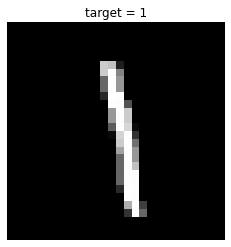

In [ ]:
image, target = [*test_dataloader][0]

random_index = numpy.random.randint(0, 64)

image, target = image[random_index, 0], target[random_index]

matplotlib.pyplot.imshow(
    image, 
    cmap="gray", 
    interpolation="nearest",
)

matplotlib.pyplot.title(f"target = {target}")
matplotlib.pyplot.axis("off")

Next, we create a PyTorch dataloader for the MNIST dataset.

Next, implement a logistic regression model in PyTorch. Note that a logistic regressor uses a linear transformation of the input.


## Exercise 1. Logistic Regression Module

In [ ]:
import torch.nn as nn

In [ ]:
class LogisticRegression(Module):
     def __init__(self, input_size: int, num_classes: int):
         super().__init__()
 
         ###########################################################################
#         # TODO: Instantiate the layer here.
         self.layer1=nn.Linear(input_size,num_classes)
         self.softmax=nn.Softmax(dim=1)                                       
#         ###########################################################################
# 
     def forward(self, x: Tensor) -> Tensor:
#         ###########################################################################
#         # TODO: Apply the layer to the input.
          x=self.layer1(x)
          x=self.softmax(x)                                
#         ###########################################################################
          return x 

In [ ]:
module = LogisticRegression(28 * 28, 10)

module = module.to(device=DEVICE)

In [ ]:
###########################################################################
# TODO: Create criterion and optimizer here.                              #
###########################################################################

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(module.parameters(),lr=0.01)

In [ ]:
train_images,train_targets=iter(train_dataloader).next()

In [ ]:
train_targets[0]

tensor(3)

## Training

We will use the following generic training loop for a PyTorch model.

In [ ]:
# Train the model. If everything is correct, the loss should go below 0.45.

EPOCHS = 5

# Exponential moving average of the loss:
ema = None

for epoch in range(EPOCHS):
    for batch_index, (train_images, train_targets) in enumerate(train_dataloader):
        train_images = train_images.view(-1, 28 * 28).requires_grad_().to(device=DEVICE)

        train_targets = train_targets.to(device=DEVICE)

      

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = module(train_images)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, train_targets)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updates parameters:
        optimizer.step()

        # NOTE: It is important to call .item() on the loss before summing.
        if ema is None:
            ema = loss.item()
        else:
            ema += (loss.item() - ema) * 0.01

        if batch_index % 500 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_index * len(train_images),
                    len(train_dataloader.dataset),
                    100.0 * batch_index / len(train_dataloader),
                    ema,
                ),
            )

Train Epoch: 0 [0/60000 (0%)]	Loss: 1.790586
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.781914
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.756951
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.749622
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.736130
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.733463
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.723196
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.718046
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.712760
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.710034


**Question:** For the model you are currently using, is there any difference between using the model in `train` mode or using it in `eval` mode? 

Create an SGD optimizer and us it to train the logistic regressor on the MNIST training data for a few epochs. What loss function do you need to use?

Answers: 

1. The `model.train()` mode actually sets the model in the training 
mode so layers such as batchnormalization, dropouts are kept active during the training phase. On the other hand, `model.eval()` deactivates this layers during the inference process.
2. The loss function used for this training is the `Cross entropy loss`, because we have multiple classes (`10` classes).




In [ ]:
# Train the model. If everything is correct, the loss should go below 0.45.

EPOCHS = 5
module.train() ### setting the model in training mode
# Exponential moving average of the loss:
ema = None

for epoch in range(EPOCHS):
    for batch_index, (train_images, train_targets) in enumerate(train_dataloader):
        train_images = train_images.view(-1, 28 * 28).requires_grad_().to(device=DEVICE)

        train_targets = train_targets.to(device=DEVICE)

      

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = module(train_images)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, train_targets)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updates parameters:
        optimizer.step()

        # NOTE: It is important to call .item() on the loss before summing.
        if ema is None:
            ema = loss.item()
        else:
            ema += (loss.item() - ema) * 0.01

        if batch_index % 500 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_index * len(train_images),
                    len(train_dataloader.dataset),
                    100.0 * batch_index / len(train_dataloader),
                    ema,
                ),
            )

### Embeddings 

Visualize the weights of the trained model. What do you see? Why?

1. From the picture below, we see classes of weights which produces values ranging from `0-9`.

In [ ]:
assert module.layer1.weight.shape == (10, 28 * 28)

(-0.5, 151.5, 61.5, -0.5)

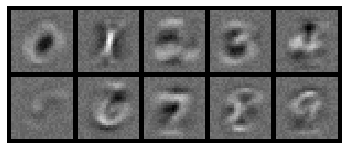

In [ ]:
matplotlib.pyplot.imshow(
    numpy.transpose(
        torchvision.utils.make_grid(
            module.layer1.weight.view(10, 1, 28, 28),
            normalize=True,
            nrow=5,
        ).to(device='cpu'), 
        (1, 2, 0),
    ), 
    interpolation="nearest",
)

matplotlib.pyplot.grid(False)
matplotlib.pyplot.gca().axis("off")

## Evaluation

Use the following function to measure the test accuracy of your trained model.

In [ ]:
correct_predictions = 0
predictions = 0

# Iterate through test dataset
for test_images, test_targets in test_dataloader:
    test_images = test_images.view(-1, 28 * 28).to(device=DEVICE)

    # Forward pass only to get logits/output
    outputs = module(test_images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)

    predictions += test_targets.size(0)

    if torch.cuda.is_available():
        correct_predictions += (predicted.cpu() == test_targets.cpu()).sum()
    else:
        correct_predictions += (predicted == test_targets).sum()

correct_predictions.item() / predictions

0.8239